In [ ]:
import cv2
import numpy as np
import os
import glob
import logging
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('ThermalPreprocessor')

def create_binary_mask(image):
    """Convert to grayscale and create binary mask"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    return gray, binary

def extract_largest_contour(binary):
    """Find and extract the largest contour"""
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    return max(contours, key=cv2.contourArea)

def get_and_order_corner_points(contour):
    """
    Finds and orders 4 corner points (TL, TR, BR, BL) from a contour
    Combines get_corner_points() and order_points() logic
    """
    # Method 1: Contour approximation
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    if len(approx) == 4:
        corners = approx.reshape(4, 2).astype(np.float32)
    else:
        # Method 2: Convex hull
        hull = cv2.convexHull(contour)
        if len(hull) == 4:
            corners = hull.reshape(4, 2).astype(np.float32)
        else:
            # Method 3: Minimum area rectangle
            rect = cv2.minAreaRect(contour)
            corners = cv2.boxPoints(rect).astype(np.float32)
    
    # Order points (TL, TR, BR, BL)
    # 1. Sort by x-coordinate
    x_sorted = corners[np.argsort(corners[:, 0])]
    
    # 2. Split into left and right points
    left_points = x_sorted[:2]
    right_points = x_sorted[2:]
    
    # 3. Sort left points by y-coordinate (top to bottom)
    left_points = left_points[np.argsort(left_points[:, 1])]
    tl, bl = left_points[0], left_points[1]
    
    # 4. Sort right points by y-coordinate (top to bottom)
    right_points = right_points[np.argsort(right_points[:, 1])]
    tr, br = right_points[0], right_points[1]
    
    return np.array([tl, tr, br, bl], dtype=np.float32)

def create_contour_visualization(original_img, box):
    """Create visualization of the detected contour"""
    contour_img = original_img.copy()
    cv2.drawContours(contour_img, [box.astype(np.int32)], -1, (0, 255, 0), 2)
    return contour_img

def apply_perspective_transform(image, box):
    """Apply perspective transformation"""
    width, height = calculate_dimensions(box)
    dst_pts = np.array([[0,0], [width-1,0], [width-1,height-1], [0,height-1]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(box, dst_pts)
    return cv2.warpPerspective(image, M, (width, height)), width, height

def adjust_image_orientation(warped):
    """Adjust image orientation based on dimensions and brightness"""
    gray_warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    h, w = gray_warped.shape[:2]
    
    if w > h:
        warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
        h, w = w, h
    
    if np.mean(gray_warped[:h//4]) > np.mean(gray_warped[3*h//4:]):
        warped = cv2.flip(warped, 0)
    
    return warped

def calculate_dimensions(box):
    """Calculate width and height from ordered points"""
    width = int(max(np.linalg.norm(box[0]-box[1]), np.linalg.norm(box[2]-box[3])))
    height = int(max(np.linalg.norm(box[1]-box[2]), np.linalg.norm(box[3]-box[0])))
    return width, height
    
def perform_tight_cropping(warped, target_size):
    """Crop tightly around the object and resize"""
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cropped = warped[y:y+h, x:x+w]
    else:
        cropped = warped
    
    return cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)

def preprocess_thermal_image(image_path, target_size=(60, 110)):
    """Main processing pipeline with refactored functions"""
    logger.info(f"Processing image: {image_path}")
    
    # 1. Read image
    image = cv2.imread(image_path)
    if image is None:
        logger.error(f"Could not read image at {image_path}")
        return None
    
    original = image.copy()
    
    # 2. Create binary mask
    gray, binary = create_binary_mask(image)
    
    # 3. Extract largest contour
    largest_contour = extract_largest_contour(binary)
    if largest_contour is None:
        logger.warning(f"No contours found in {os.path.basename(image_path)}!")
        return None
    
    # 4. Get ordered corner points (NO VISUALIZATION HERE)
    ordered_corners = get_and_order_corner_points(largest_contour)
    if ordered_corners is None or len(ordered_corners) != 4:
        logger.warning(f"Could not find 4 corners for {os.path.basename(image_path)}")
        return None
    
    # 5. Apply perspective transform
    warped, width, height = apply_perspective_transform(image, ordered_corners)
    
    # 6. Adjust orientation
    oriented = adjust_image_orientation(warped)
    
    # 7. Crop and resize
    processed = perform_tight_cropping(oriented, target_size)
    
    return {
        'original': original,
        'binary': binary,
        'processed': processed,
        'largest_contour': largest_contour,
        'corners': ordered_corners,  # Changed from 'box' to 'corners'
        'warped_size': (width, height)
    }

def visualize_processing_steps(results, image_path, class_name=None):
    """Visualize all processing steps in a single row"""
    if results is None:
        logger.warning("Cannot visualize invalid data")
        return
    
    # Create visualization only when needed
    contour_img = results['original'].copy()
    cv2.drawContours(contour_img, 
                    [results['corners'].astype(np.int32)], 
                    -1, (0, 255, 0), 2)

    # Create single row with 4 columns
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    img_name = os.path.basename(image_path)
    
    # 1. Original Image
    ax[0].imshow(cv2.cvtColor(results['original'], cv2.COLOR_BGR2RGB))
    ax[0].set_title("1. Original Image")
    ax[0].axis("off")
    
    # 2. Binary Mask with Contour Points
    ax[1].imshow(results['binary'], cmap="gray")
    if results['largest_contour'] is not None:
        for point in results['largest_contour']:
            ax[1].plot(point[0][0], point[0][1], 'r.', markersize=2)
    ax[1].set_title("2. Binary Mask with Points")
    ax[1].axis("off")
    
    # 3. Contour Visualization
    ax[2].imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
    ax[2].set_title("3. Detected Contour")
    ax[2].axis("off")
    
    # 4. Processed Image
    ax[3].imshow(cv2.cvtColor(results['processed'], cv2.COLOR_BGR2RGB))
    ax[3].set_title(f"4. Processed\n{results['processed'].shape[1]}x{results['processed'].shape[0]}")
    ax[3].axis("off")
    
    plt.suptitle(f"Class: {class_name}\nImage: {img_name}", y=1.1)
    plt.tight_layout()
    plt.show()
    
def process_dataset(input_folder, output_folder, target_size=(60, 110)):
    """Process all images in all subfolders"""
    subfolders = [f.path for f in os.scandir(input_folder) if f.is_dir()]
    
    for subfolder in subfolders:
        class_name = os.path.basename(subfolder)
        output_subfolder = os.path.join(output_folder, class_name)
        os.makedirs(output_subfolder, exist_ok=True)
        
        logger.info(f"Processing class: {class_name}")
        
        # Process images in the subfolder
        image_files = glob.glob(os.path.join(subfolder, "*.tif"))
        visualized = False
        
        for img_path in image_files:
            results = preprocess_thermal_image(img_path, target_size)
            
            if results is not None:
                output_path = os.path.join(output_subfolder, os.path.basename(img_path))
                cv2.imwrite(output_path, results['processed'])
                logger.info(f"Saved processed image for {class_name}/{os.path.basename(img_path)}")
                
                # Visualize the first successful image in each class
                if not visualized:
                    visualize_processing_steps(results, img_path, class_name)
                    visualized = True


def main():
    input_folder = "C:/Users/tanan/Downloads/anchee_fyp2/PVF-10/PVF_10_Original"
    output_folder = "C:/Users/tanan/Downloads/anchee_fyp2/PVF-10/PVF_10_Try"

    logger.info("Preprocessing PVF-10 dataset...")
    process_dataset(input_folder, output_folder)

    logger.info("Preprocessing complete!")


if __name__ == "__main__":
    main()

2025-06-27 01:07:04,955 - ThermalPreprocessor - INFO - Preprocessing PVF-10 dataset...


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/tanan/Downloads/anchee_fyp2/PVF-10/PVF_10_Original'

In [ ]:
import cv2
import numpy as np
import os
import glob
import logging
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('ThermalPreprocessor')

def create_binary_mask(image):
    """Convert to grayscale and create binary mask"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    return gray, binary

def extract_largest_contour(binary):
    """Find and extract the largest contour"""
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    return max(contours, key=cv2.contourArea)

def get_and_order_corner_points(contour):
    """
    Finds and orders 4 corner points (TL, TR, BR, BL) from a contour
    Combines get_corner_points() and order_points() logic
    """
    # Method 1: Contour approximation
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    if len(approx) == 4:
        corners = approx.reshape(4, 2).astype(np.float32)
    else:
        # Method 2: Convex hull
        hull = cv2.convexHull(contour)
        if len(hull) == 4:
            corners = hull.reshape(4, 2).astype(np.float32)
        else:
            # Method 3: Minimum area rectangle
            rect = cv2.minAreaRect(contour)
            corners = cv2.boxPoints(rect).astype(np.float32)
    
    # Order points (TL, TR, BR, BL)
    # 1. Sort by x-coordinate
    x_sorted = corners[np.argsort(corners[:, 0])]
    
    # 2. Split into left and right points
    left_points = x_sorted[:2]
    right_points = x_sorted[2:]
    
    # 3. Sort left points by y-coordinate (top to bottom)
    left_points = left_points[np.argsort(left_points[:, 1])]
    tl, bl = left_points[0], left_points[1]
    
    # 4. Sort right points by y-coordinate (top to bottom)
    right_points = right_points[np.argsort(right_points[:, 1])]
    tr, br = right_points[0], right_points[1]
    
    return np.array([tl, tr, br, bl], dtype=np.float32)

def create_contour_visualization(original_img, box):
    """Create visualization of the detected contour"""
    contour_img = original_img.copy()
    cv2.drawContours(contour_img, [box.astype(np.int32)], -1, (0, 255, 0), 2)
    return contour_img

def apply_perspective_transform(image, box):
    """Apply perspective transformation"""
    width, height = calculate_dimensions(box)
    dst_pts = np.array([[0,0], [width-1,0], [width-1,height-1], [0,height-1]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(box, dst_pts)
    return cv2.warpPerspective(image, M, (width, height)), width, height

def adjust_image_orientation(warped):
    """Adjust image orientation based on dimensions and brightness"""
    gray_warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    h, w = gray_warped.shape[:2]
    
    if w > h:
        warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
        h, w = w, h
    
    if np.mean(gray_warped[:h//4]) > np.mean(gray_warped[3*h//4:]):
        warped = cv2.flip(warped, 0)
    
    return warped

def calculate_dimensions(box):
    """Calculate width and height from ordered points"""
    width = int(max(np.linalg.norm(box[0]-box[1]), np.linalg.norm(box[2]-box[3])))
    height = int(max(np.linalg.norm(box[1]-box[2]), np.linalg.norm(box[3]-box[0])))
    return width, height
    
def perform_tight_cropping(warped, target_size):
    """Crop tightly around the object and resize"""
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cropped = warped[y:y+h, x:x+w]
    else:
        cropped = warped
    
    return cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)

def preprocess_thermal_image(image_path, target_size=(60, 110)):
    """Main processing pipeline with refactored functions"""
    logger.info(f"Processing image: {image_path}")
    
    # 1. Read image
    image = cv2.imread(image_path)
    if image is None:
        logger.error(f"Could not read image at {image_path}")
        return None
    
    original = image.copy()
    
    # 2. Create binary mask
    gray, binary = create_binary_mask(image)
    
    # 3. Extract largest contour
    largest_contour = extract_largest_contour(binary)
    if largest_contour is None:
        logger.warning(f"No contours found in {os.path.basename(image_path)}!")
        return None
    
    # 4. Get ordered corner points (NO VISUALIZATION HERE)
    ordered_corners = get_and_order_corner_points(largest_contour)
    if ordered_corners is None or len(ordered_corners) != 4:
        logger.warning(f"Could not find 4 corners for {os.path.basename(image_path)}")
        return None
    
    # 5. Apply perspective transform
    warped, width, height = apply_perspective_transform(image, ordered_corners)
    
    # 6. Adjust orientation
    oriented = adjust_image_orientation(warped)
    
    # 7. Crop and resize
    processed = perform_tight_cropping(oriented, target_size)
    
    return {
        'original': original,
        'binary': binary,
        'processed': processed,
        'largest_contour': largest_contour,
        'corners': ordered_corners,  # Changed from 'box' to 'corners'
        'warped_size': (width, height)
    }

def visualize_processing_steps(results, image_path, class_name=None):
    """Visualize all processing steps in a single row"""
    if results is None:
        logger.warning("Cannot visualize invalid data")
        return
    
    # Create visualization only when needed
    contour_img = results['original'].copy()
    cv2.drawContours(contour_img, 
                    [results['corners'].astype(np.int32)], 
                    -1, (0, 255, 0), 2)

    # Create single row with 4 columns
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    img_name = os.path.basename(image_path)
    
    # 1. Original Image
    ax[0].imshow(cv2.cvtColor(results['original'], cv2.COLOR_BGR2RGB))
    ax[0].set_title("1. Original Image")
    ax[0].axis("off")
    
    # 2. Binary Mask with Contour Points
    ax[1].imshow(results['binary'], cmap="gray")
    if results['largest_contour'] is not None:
        for point in results['largest_contour']:
            ax[1].plot(point[0][0], point[0][1], 'r.', markersize=2)
    ax[1].set_title("2. Binary Mask with Points")
    ax[1].axis("off")
    
    # 3. Contour Visualization
    ax[2].imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
    ax[2].set_title("3. Detected Contour")
    ax[2].axis("off")
    
    # 4. Processed Image
    ax[3].imshow(cv2.cvtColor(results['processed'], cv2.COLOR_BGR2RGB))
    ax[3].set_title(f"4. Processed\n{results['processed'].shape[1]}x{results['processed'].shape[0]}")
    ax[3].axis("off")
    
    plt.suptitle(f"Class: {class_name}\nImage: {img_name}", y=1.1)
    plt.tight_layout()
    plt.show()
    
def process_dataset(input_folder, output_folder, target_size=(60, 110)):
    """Process all images in all subfolders"""
    subfolders = [f.path for f in os.scandir(input_folder) if f.is_dir()]
    
    for subfolder in subfolders:
        class_name = os.path.basename(subfolder)
        output_subfolder = os.path.join(output_folder, class_name)
        os.makedirs(output_subfolder, exist_ok=True)
        
        logger.info(f"Processing class: {class_name}")
        
        # Process images in the subfolder
        image_files = glob.glob(os.path.join(subfolder, "*.tif"))
        visualized = False
        
        for img_path in image_files:
            results = preprocess_thermal_image(img_path, target_size)
            
            if results is not None:
                output_path = os.path.join(output_subfolder, os.path.basename(img_path))
                cv2.imwrite(output_path, results['processed'])
                logger.info(f"Saved processed image for {class_name}/{os.path.basename(img_path)}")
                
                # Visualize the first successful image in each class
                if not visualized:
                    visualize_processing_steps(results, img_path, class_name)
                    visualized = True


def main():
    input_folder = r"C:/Users/tanan/Downloads/anchee_fyp2/PVF-10/PVF_10_Original"
    output_folder = r"C:/Users/tanan/Downloads/anchee_fyp2/PVF-10/PVF_10_Try"

    logger.info("Preprocessing PVF-10 dataset...")
    process_dataset(input_folder, output_folder)

    logger.info("Preprocessing complete!")


if __name__ == "__main__":
    main()

2025-06-27 01:07:23,535 - ThermalPreprocessor - INFO - Preprocessing PVF-10 dataset...


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:/Users/tanan/Downloads/anchee_fyp2/PVF-10/PVF_10_Original'

2025-06-27 01:07:54,052 - ThermalPreprocessor - INFO - Preprocessing PVF-10 dataset...
2025-06-27 01:07:54,056 - ThermalPreprocessor - INFO - Processing class: 01substring open circuit
2025-06-27 01:07:54,108 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\01substring open circuit\DJI_20230222130253_0277_T_000007.tif
2025-06-27 01:07:54,187 - ThermalPreprocessor - INFO - Saved processed image for 01substring open circuit/DJI_20230222130253_0277_T_000007.tif


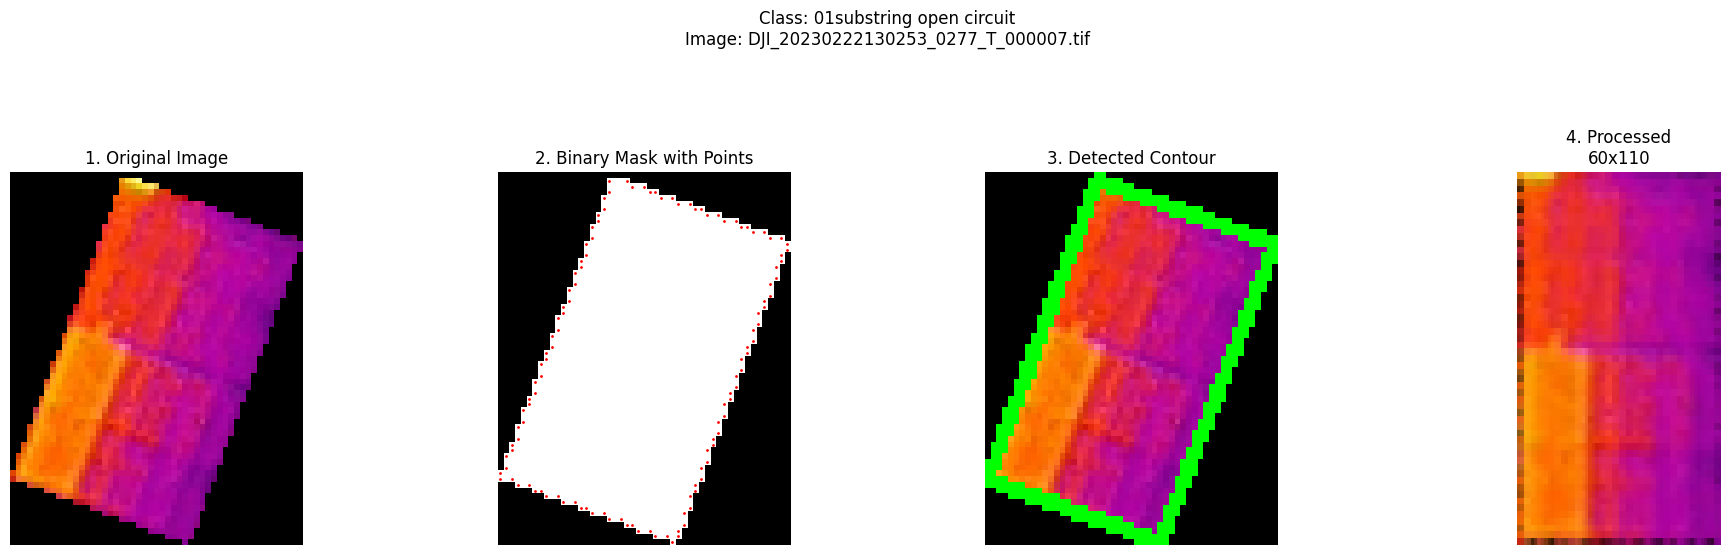

2025-06-27 01:07:54,801 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\01substring open circuit\DJI_20230222130345_0306_T_000009.tif
2025-06-27 01:07:54,836 - ThermalPreprocessor - INFO - Saved processed image for 01substring open circuit/DJI_20230222130345_0306_T_000009.tif
2025-06-27 01:07:54,837 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\01substring open circuit\DJI_20230222143638_0628_T_000002.tif
C:\Users\tanan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tanan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered

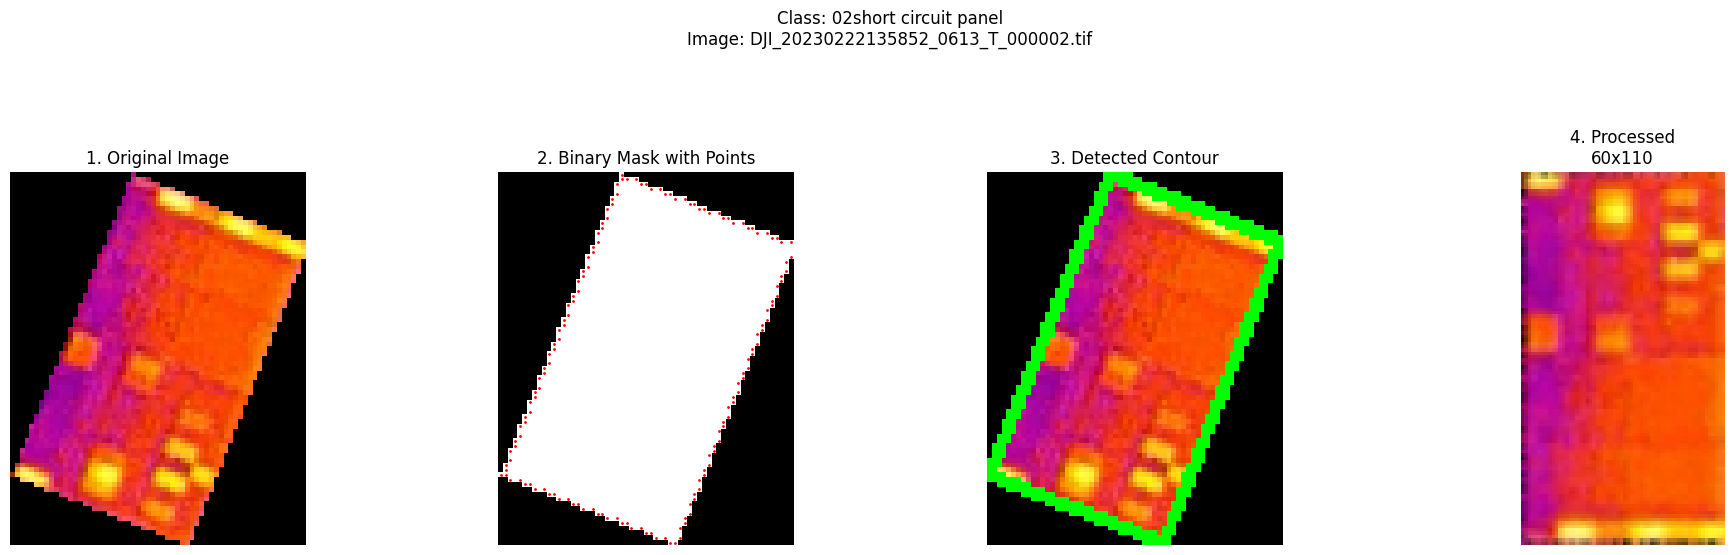

2025-06-27 01:08:06,598 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\02short circuit panel\DJI_20230222140342_0737_T_000001.tif
2025-06-27 01:08:06,606 - ThermalPreprocessor - INFO - Saved processed image for 02short circuit panel/DJI_20230222140342_0737_T_000001.tif
2025-06-27 01:08:06,606 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\02short circuit panel\DJI_20230222140342_0737_T_000002.tif
2025-06-27 01:08:06,629 - ThermalPreprocessor - INFO - Saved processed image for 02short circuit panel/DJI_20230222140342_0737_T_000002.tif
2025-06-27 01:08:06,630 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\02short circuit panel\DJI_20230222140342_0737_T_000003.tif
2025-06-27 01:08:06,646 - ThermalPreprocessor - INFO - Saved processed image for 02short circuit panel/DJI_20230222140342_0737_T_000003.tif
2025

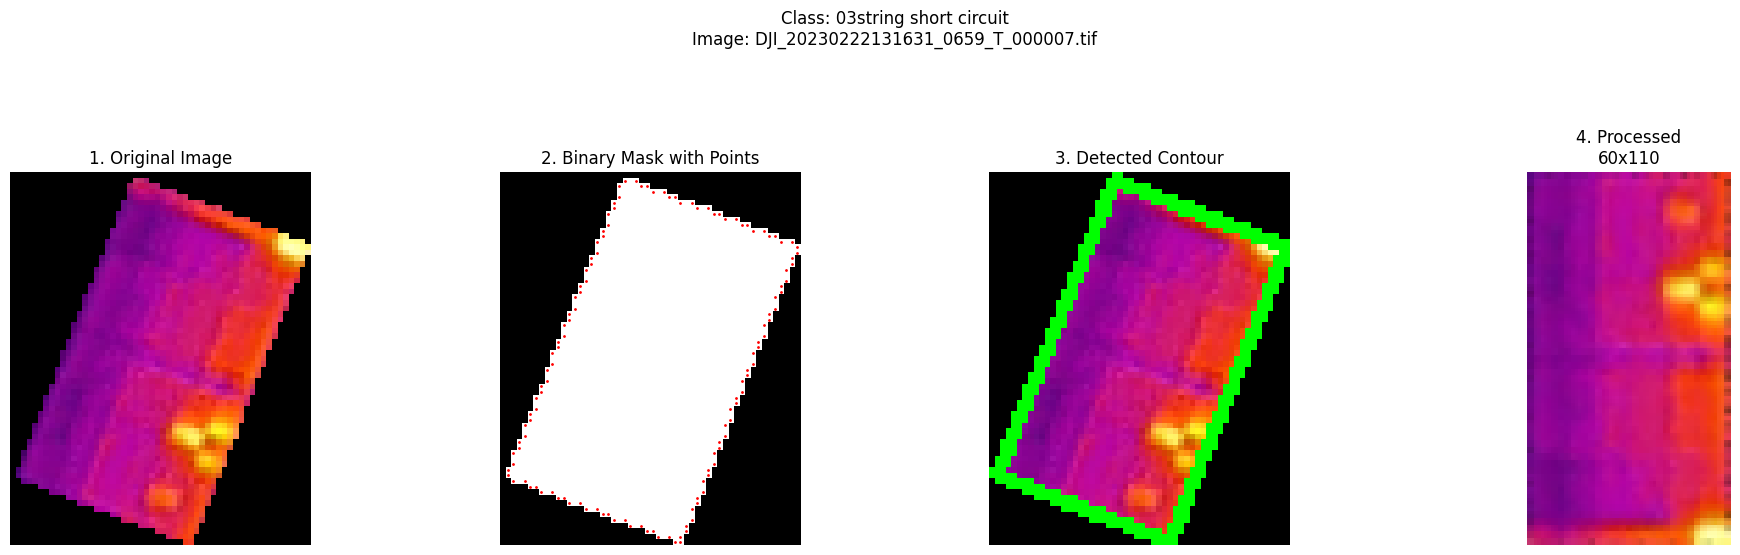

2025-06-27 01:08:14,939 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\03string short circuit\DJI_20230222131631_0659_T_000010.tif
2025-06-27 01:08:14,952 - ThermalPreprocessor - INFO - Saved processed image for 03string short circuit/DJI_20230222131631_0659_T_000010.tif
2025-06-27 01:08:14,953 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\03string short circuit\DJI_20230222131634_0660_T_000005.tif
2025-06-27 01:08:14,967 - ThermalPreprocessor - INFO - Saved processed image for 03string short circuit/DJI_20230222131634_0660_T_000005.tif
2025-06-27 01:08:14,969 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\03string short circuit\DJI_20230222131739_0687_T_000006.tif
2025-06-27 01:08:14,984 - ThermalPreprocessor - INFO - Saved processed image for 03string short circuit/DJI_20230222131739_0687_T_000006.ti

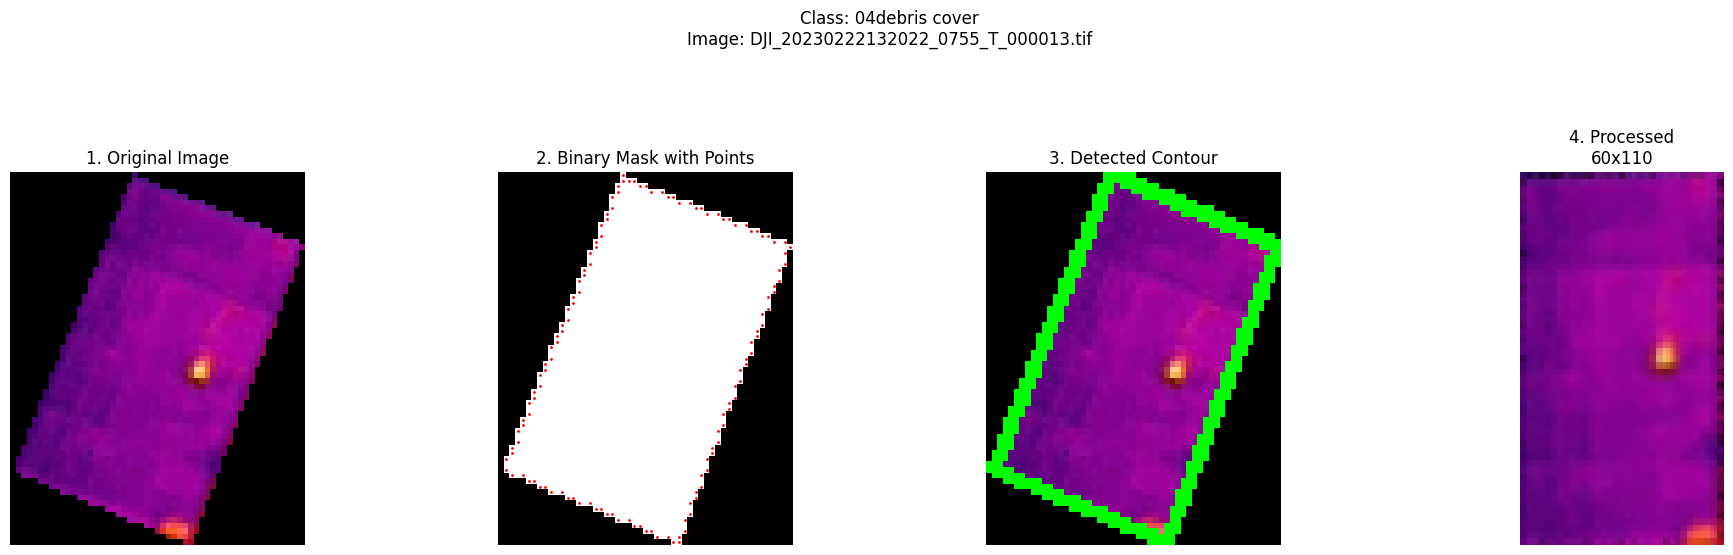

2025-06-27 01:08:16,472 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\04debris cover\DJI_20230222132441_0860_T_000004.tif
2025-06-27 01:08:16,489 - ThermalPreprocessor - INFO - Saved processed image for 04debris cover/DJI_20230222132441_0860_T_000004.tif
2025-06-27 01:08:16,489 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\04debris cover\DJI_20230222140231_0707_T_000016.tif
2025-06-27 01:08:16,512 - ThermalPreprocessor - INFO - Saved processed image for 04debris cover/DJI_20230222140231_0707_T_000016.tif
2025-06-27 01:08:16,513 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\04debris cover\DJI_20230222141918_0051_T_000020.tif
2025-06-27 01:08:16,525 - ThermalPreprocessor - INFO - Saved processed image for 04debris cover/DJI_20230222141918_0051_T_000020.tif
2025-06-27 01:08:16,526 - ThermalPreprocessor 

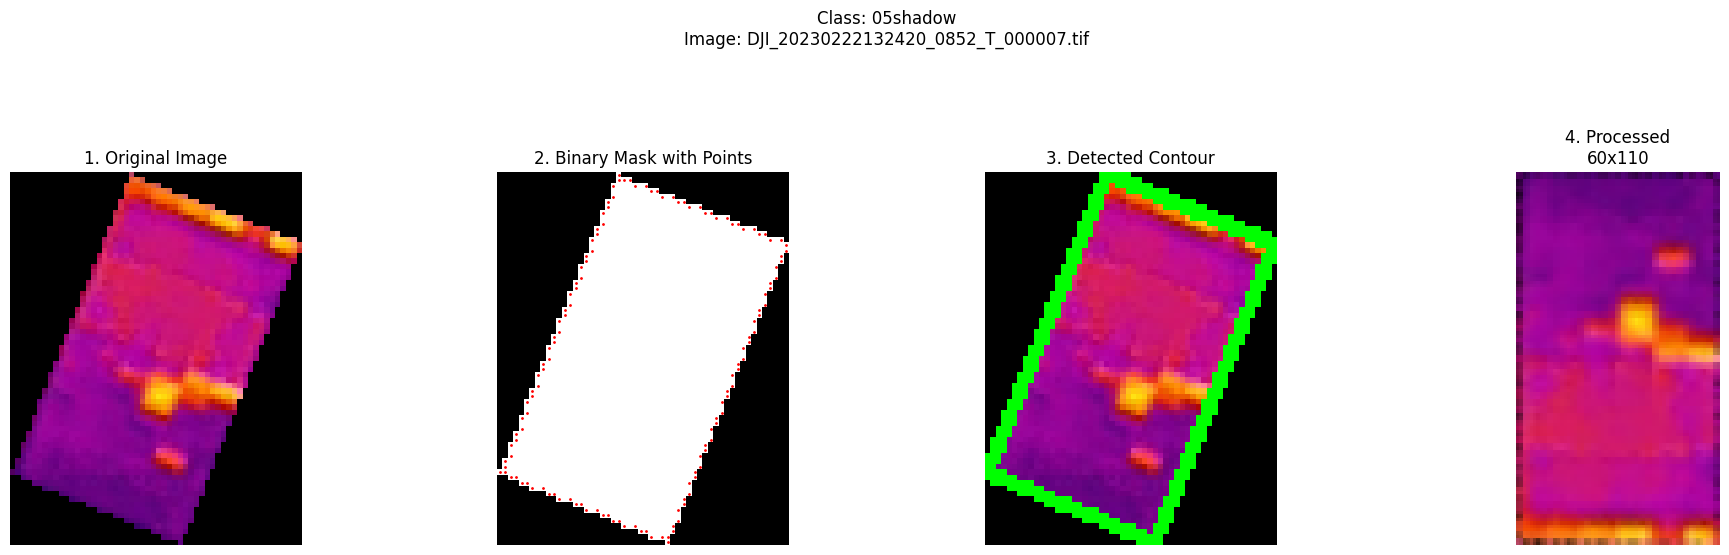

2025-06-27 01:08:25,058 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\05shadow\DJI_20230222143638_0628_T_000003.tif
2025-06-27 01:08:25,073 - ThermalPreprocessor - INFO - Saved processed image for 05shadow/DJI_20230222143638_0628_T_000003.tif
2025-06-27 01:08:25,073 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\05shadow\DJI_20230222143638_0628_T_000004.tif
2025-06-27 01:08:25,102 - ThermalPreprocessor - INFO - Saved processed image for 05shadow/DJI_20230222143638_0628_T_000004.tif
2025-06-27 01:08:25,105 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\05shadow\DJI_20230222143638_0628_T_000005.tif
2025-06-27 01:08:25,116 - ThermalPreprocessor - INFO - Saved processed image for 05shadow/DJI_20230222143638_0628_T_000005.tif
2025-06-27 01:08:25,118 - ThermalPreprocessor - INFO - Processing image: C:\Users\

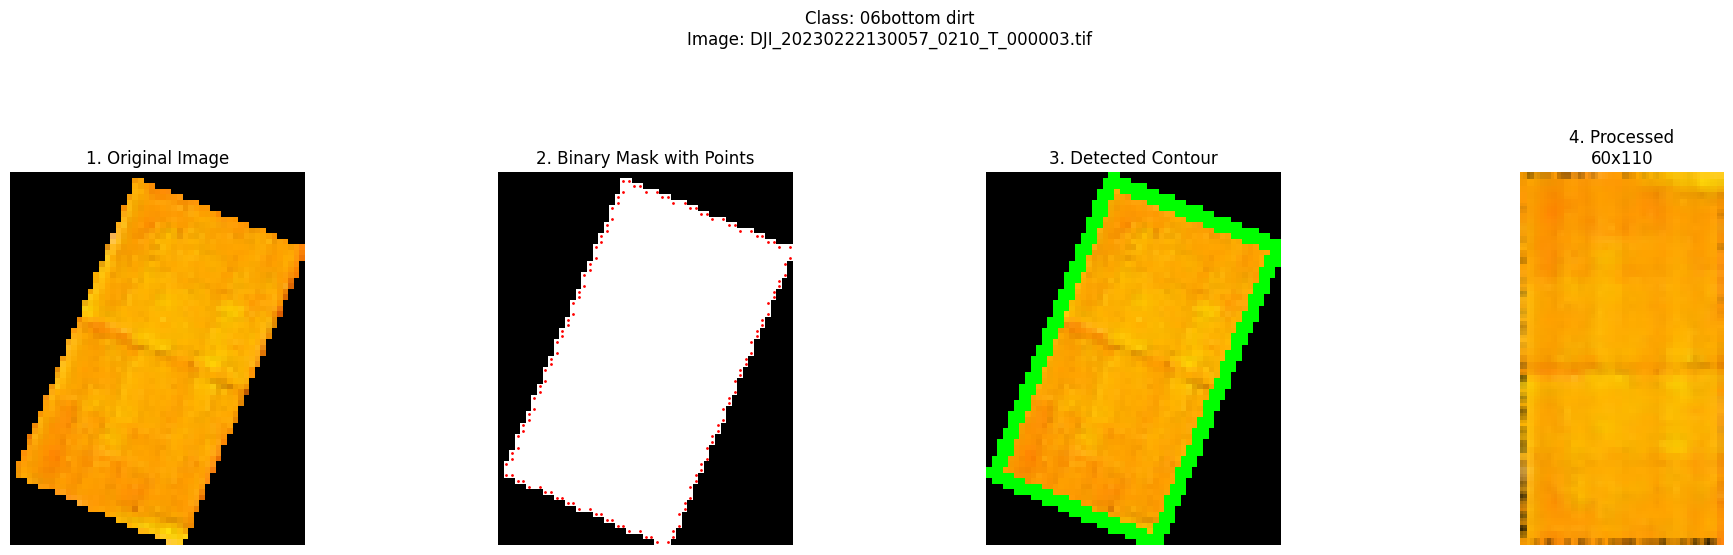

2025-06-27 01:08:31,901 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\06bottom dirt\DJI_20230222130057_0210_T_000007.tif
2025-06-27 01:08:31,922 - ThermalPreprocessor - INFO - Saved processed image for 06bottom dirt/DJI_20230222130057_0210_T_000007.tif
2025-06-27 01:08:31,922 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\06bottom dirt\DJI_20230222130104_0215_T_000004.tif
2025-06-27 01:08:31,958 - ThermalPreprocessor - INFO - Saved processed image for 06bottom dirt/DJI_20230222130104_0215_T_000004.tif
2025-06-27 01:08:31,961 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\06bottom dirt\DJI_20230222130104_0215_T_000005.tif
2025-06-27 01:08:31,978 - ThermalPreprocessor - INFO - Saved processed image for 06bottom dirt/DJI_20230222130104_0215_T_000005.tif
2025-06-27 01:08:31,983 - ThermalPreprocessor - INFO

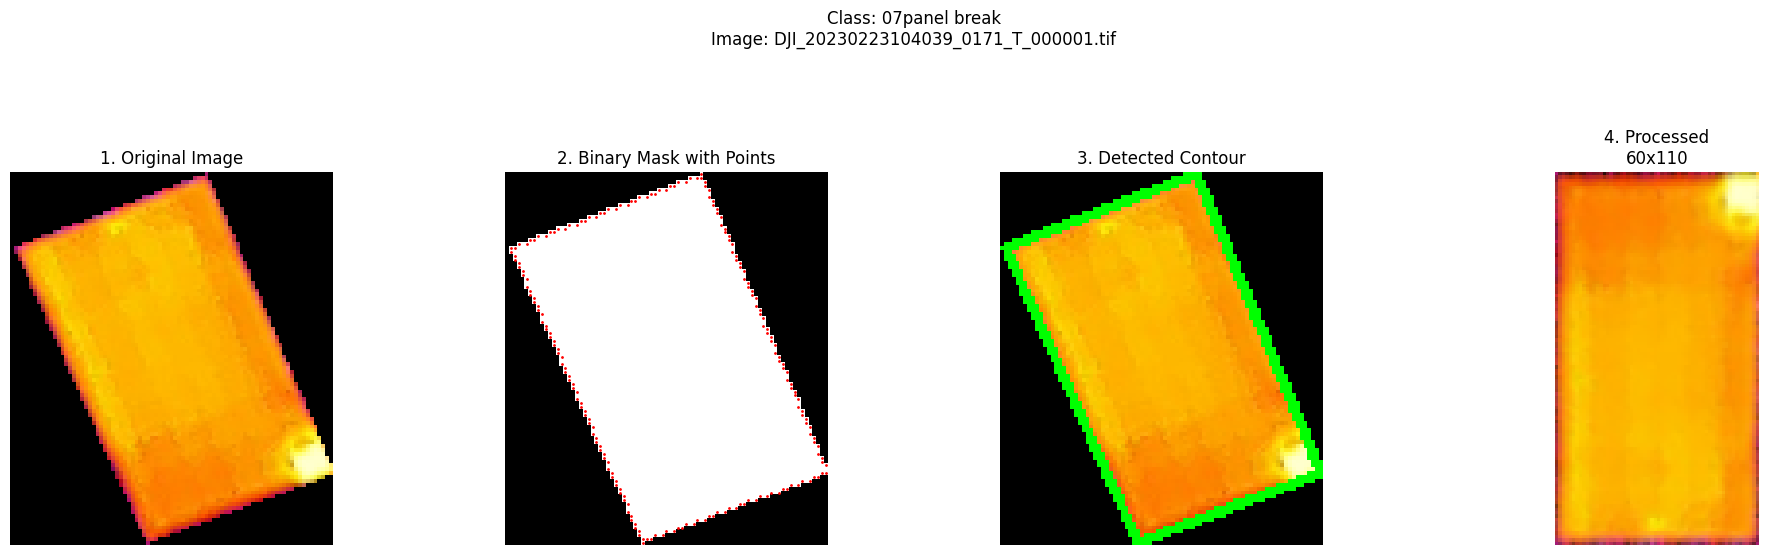

2025-06-27 01:08:41,365 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\07panel break\DJI_20230223104039_0171_T_000002.tif
2025-06-27 01:08:41,391 - ThermalPreprocessor - INFO - Saved processed image for 07panel break/DJI_20230223104039_0171_T_000002.tif
2025-06-27 01:08:41,394 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\07panel break\DJI_20230223104424_0277_T_000011.tif
2025-06-27 01:08:41,431 - ThermalPreprocessor - INFO - Saved processed image for 07panel break/DJI_20230223104424_0277_T_000011.tif
2025-06-27 01:08:41,433 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\07panel break\DJI_20230223104424_0277_T_000015.tif
2025-06-27 01:08:41,477 - ThermalPreprocessor - INFO - Saved processed image for 07panel break/DJI_20230223104424_0277_T_000015.tif
2025-06-27 01:08:41,486 - ThermalPreprocessor - INFO

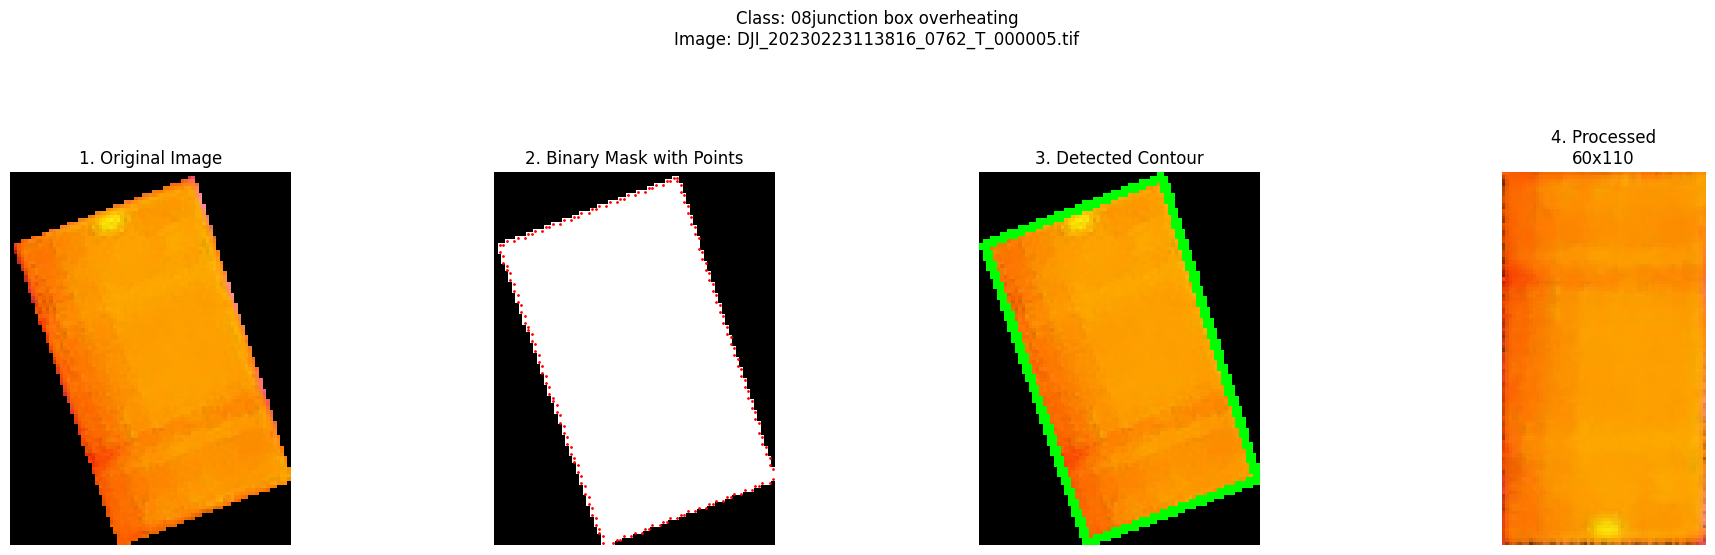

2025-06-27 01:08:45,547 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\08junction box overheating\DJI_20230223113816_0762_T_000006.tif
2025-06-27 01:08:45,566 - ThermalPreprocessor - INFO - Saved processed image for 08junction box overheating/DJI_20230223113816_0762_T_000006.tif
2025-06-27 01:08:45,590 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\08junction box overheating\DJI_20230223113816_0762_T_000007.tif
2025-06-27 01:08:45,633 - ThermalPreprocessor - INFO - Saved processed image for 08junction box overheating/DJI_20230223113816_0762_T_000007.tif
2025-06-27 01:08:45,636 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\08junction box overheating\DJI_20230223113857_0779_T_000006.tif
2025-06-27 01:08:45,676 - ThermalPreprocessor - INFO - Saved processed image for 08junction box overheating/DJI_2023022

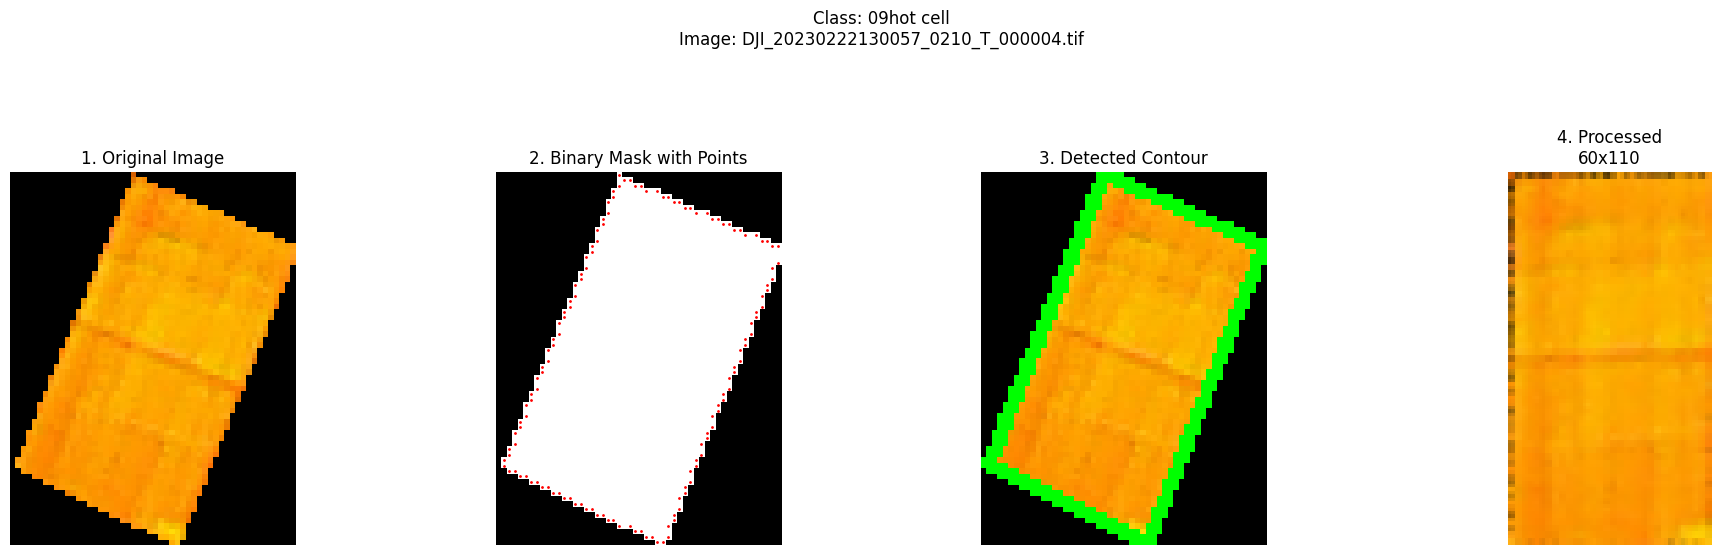

2025-06-27 01:09:02,212 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\09hot cell\DJI_20230222130057_0210_T_000005.tif
2025-06-27 01:09:02,227 - ThermalPreprocessor - INFO - Saved processed image for 09hot cell/DJI_20230222130057_0210_T_000005.tif
2025-06-27 01:09:02,228 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\09hot cell\DJI_20230222130057_0210_T_000006.tif
2025-06-27 01:09:02,242 - ThermalPreprocessor - INFO - Saved processed image for 09hot cell/DJI_20230222130057_0210_T_000006.tif
2025-06-27 01:09:02,246 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\09hot cell\DJI_20230222130057_0210_T_000008.tif
2025-06-27 01:09:02,262 - ThermalPreprocessor - INFO - Saved processed image for 09hot cell/DJI_20230222130057_0210_T_000008.tif
2025-06-27 01:09:02,263 - ThermalPreprocessor - INFO - Processing imag

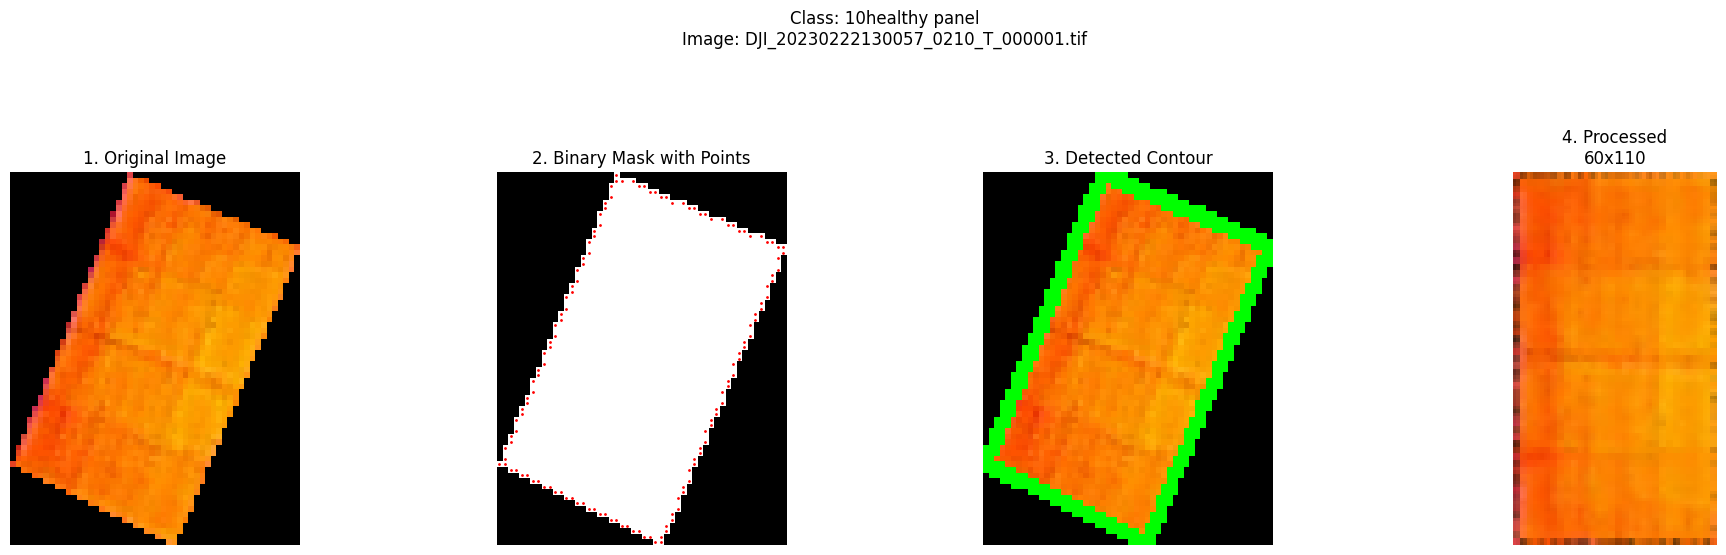

2025-06-27 01:09:24,447 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\10healthy panel\DJI_20230222130057_0210_T_000002.tif
2025-06-27 01:09:24,475 - ThermalPreprocessor - INFO - Saved processed image for 10healthy panel/DJI_20230222130057_0210_T_000002.tif
2025-06-27 01:09:24,475 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\10healthy panel\DJI_20230222130057_0210_T_000011.tif
2025-06-27 01:09:24,506 - ThermalPreprocessor - INFO - Saved processed image for 10healthy panel/DJI_20230222130057_0210_T_000011.tif
2025-06-27 01:09:24,508 - ThermalPreprocessor - INFO - Processing image: C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original\10healthy panel\DJI_20230222130104_0215_T_000001.tif
2025-06-27 01:09:24,530 - ThermalPreprocessor - INFO - Saved processed image for 10healthy panel/DJI_20230222130104_0215_T_000001.tif
2025-06-27 01:09:24,532 - ThermalPreproc

In [ ]:
import cv2
import numpy as np
import os
import glob
import logging
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('ThermalPreprocessor')

def create_binary_mask(image):
    """Convert to grayscale and create binary mask"""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    return gray, binary

def extract_largest_contour(binary):
    """Find and extract the largest contour"""
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None
    return max(contours, key=cv2.contourArea)

def get_and_order_corner_points(contour):
    """
    Finds and orders 4 corner points (TL, TR, BR, BL) from a contour
    Combines get_corner_points() and order_points() logic
    """
    # Method 1: Contour approximation
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    if len(approx) == 4:
        corners = approx.reshape(4, 2).astype(np.float32)
    else:
        # Method 2: Convex hull
        hull = cv2.convexHull(contour)
        if len(hull) == 4:
            corners = hull.reshape(4, 2).astype(np.float32)
        else:
            # Method 3: Minimum area rectangle
            rect = cv2.minAreaRect(contour)
            corners = cv2.boxPoints(rect).astype(np.float32)
    
    # Order points (TL, TR, BR, BL)
    # 1. Sort by x-coordinate
    x_sorted = corners[np.argsort(corners[:, 0])]
    
    # 2. Split into left and right points
    left_points = x_sorted[:2]
    right_points = x_sorted[2:]
    
    # 3. Sort left points by y-coordinate (top to bottom)
    left_points = left_points[np.argsort(left_points[:, 1])]
    tl, bl = left_points[0], left_points[1]
    
    # 4. Sort right points by y-coordinate (top to bottom)
    right_points = right_points[np.argsort(right_points[:, 1])]
    tr, br = right_points[0], right_points[1]
    
    return np.array([tl, tr, br, bl], dtype=np.float32)

def create_contour_visualization(original_img, box):
    """Create visualization of the detected contour"""
    contour_img = original_img.copy()
    cv2.drawContours(contour_img, [box.astype(np.int32)], -1, (0, 255, 0), 2)
    return contour_img

def apply_perspective_transform(image, box):
    """Apply perspective transformation"""
    width, height = calculate_dimensions(box)
    dst_pts = np.array([[0,0], [width-1,0], [width-1,height-1], [0,height-1]], dtype=np.float32)
    M = cv2.getPerspectiveTransform(box, dst_pts)
    return cv2.warpPerspective(image, M, (width, height)), width, height

def adjust_image_orientation(warped):
    """Adjust image orientation based on dimensions and brightness"""
    gray_warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    h, w = gray_warped.shape[:2]
    
    if w > h:
        warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
        h, w = w, h
    
    if np.mean(gray_warped[:h//4]) > np.mean(gray_warped[3*h//4:]):
        warped = cv2.flip(warped, 0)
    
    return warped

def calculate_dimensions(box):
    """Calculate width and height from ordered points"""
    width = int(max(np.linalg.norm(box[0]-box[1]), np.linalg.norm(box[2]-box[3])))
    height = int(max(np.linalg.norm(box[1]-box[2]), np.linalg.norm(box[3]-box[0])))
    return width, height
    
def perform_tight_cropping(warped, target_size):
    """Crop tightly around the object and resize"""
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cropped = warped[y:y+h, x:x+w]
    else:
        cropped = warped
    
    return cv2.resize(cropped, target_size, interpolation=cv2.INTER_AREA)

def preprocess_thermal_image(image_path, target_size=(60, 110)):
    """Main processing pipeline with refactored functions"""
    logger.info(f"Processing image: {image_path}")
    
    # 1. Read image
    image = cv2.imread(image_path)
    if image is None:
        logger.error(f"Could not read image at {image_path}")
        return None
    
    original = image.copy()
    
    # 2. Create binary mask
    gray, binary = create_binary_mask(image)
    
    # 3. Extract largest contour
    largest_contour = extract_largest_contour(binary)
    if largest_contour is None:
        logger.warning(f"No contours found in {os.path.basename(image_path)}!")
        return None
    
    # 4. Get ordered corner points (NO VISUALIZATION HERE)
    ordered_corners = get_and_order_corner_points(largest_contour)
    if ordered_corners is None or len(ordered_corners) != 4:
        logger.warning(f"Could not find 4 corners for {os.path.basename(image_path)}")
        return None
    
    # 5. Apply perspective transform
    warped, width, height = apply_perspective_transform(image, ordered_corners)
    
    # 6. Adjust orientation
    oriented = adjust_image_orientation(warped)
    
    # 7. Crop and resize
    processed = perform_tight_cropping(oriented, target_size)
    
    return {
        'original': original,
        'binary': binary,
        'processed': processed,
        'largest_contour': largest_contour,
        'corners': ordered_corners,  # Changed from 'box' to 'corners'
        'warped_size': (width, height)
    }

def visualize_processing_steps(results, image_path, class_name=None):
    """Visualize all processing steps in a single row"""
    if results is None:
        logger.warning("Cannot visualize invalid data")
        return
    
    # Create visualization only when needed
    contour_img = results['original'].copy()
    cv2.drawContours(contour_img, 
                    [results['corners'].astype(np.int32)], 
                    -1, (0, 255, 0), 2)

    # Create single row with 4 columns
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    img_name = os.path.basename(image_path)
    
    # 1. Original Image
    ax[0].imshow(cv2.cvtColor(results['original'], cv2.COLOR_BGR2RGB))
    ax[0].set_title("1. Original Image")
    ax[0].axis("off")
    
    # 2. Binary Mask with Contour Points
    ax[1].imshow(results['binary'], cmap="gray")
    if results['largest_contour'] is not None:
        for point in results['largest_contour']:
            ax[1].plot(point[0][0], point[0][1], 'r.', markersize=2)
    ax[1].set_title("2. Binary Mask with Points")
    ax[1].axis("off")
    
    # 3. Contour Visualization
    ax[2].imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
    ax[2].set_title("3. Detected Contour")
    ax[2].axis("off")
    
    # 4. Processed Image
    ax[3].imshow(cv2.cvtColor(results['processed'], cv2.COLOR_BGR2RGB))
    ax[3].set_title(f"4. Processed\n{results['processed'].shape[1]}x{results['processed'].shape[0]}")
    ax[3].axis("off")
    
    plt.suptitle(f"Class: {class_name}\nImage: {img_name}", y=1.1)
    plt.tight_layout()
    plt.show()
    
def process_dataset(input_folder, output_folder, target_size=(60, 110)):
    """Process all images in all subfolders"""
    subfolders = [f.path for f in os.scandir(input_folder) if f.is_dir()]
    
    for subfolder in subfolders:
        class_name = os.path.basename(subfolder)
        output_subfolder = os.path.join(output_folder, class_name)
        os.makedirs(output_subfolder, exist_ok=True)
        
        logger.info(f"Processing class: {class_name}")
        
        # Process images in the subfolder
        image_files = glob.glob(os.path.join(subfolder, "*.tif"))
        visualized = False
        
        for img_path in image_files:
            results = preprocess_thermal_image(img_path, target_size)
            
            if results is not None:
                output_path = os.path.join(output_subfolder, os.path.basename(img_path))
                cv2.imwrite(output_path, results['processed'])
                logger.info(f"Saved processed image for {class_name}/{os.path.basename(img_path)}")
                
                # Visualize the first successful image in each class
                if not visualized:
                    visualize_processing_steps(results, img_path, class_name)
                    visualized = True


def main():
    input_folder = r"C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Original"
    output_folder = r"C:\Users\tanan\Downloads\anchee_fyp2\PVF_10\PVF_10_Try"

    logger.info("Preprocessing PVF-10 dataset...")
    process_dataset(input_folder, output_folder)

    logger.info("Preprocessing complete!")


if __name__ == "__main__":
    main()